In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import os
os.chdir('/Users/sebas/projects/metabolomics')
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

In [52]:
from src.transformers.sklearn_model import SklearnModel
import gensim
from src.load_data import LoadData
from src.config import Config
from tqdm import tqdm
from src.loader_saver import LoaderSaver
import itertools
import numpy as np
from scipy.stats import spearmanr
import dill
from src.plotting import Plotting
from src.load_data import LoadData
from src.molecule_pairs_opt import MoleculePairsOpt
from sklearn.model_selection import train_test_split
from src.train_utils import TrainUtils
from src.preprocessor import Preprocessor
import pickle
import sys
from src.config import Config
from src.parser import Parser
from datetime import datetime
from src.loader_saver import LoaderSaver
from src.molecular_pairs_set import MolecularPairsSet
from scipy.stats import spearmanr
from src.transformers.embedder import Embedder
from src.transformers.encoder import Encoder
import matplotlib.pyplot as plt
from src.transformers.CustomDatasetEncoder import CustomDatasetEncoder
from src.transformers.load_data_encoder import LoadDataEncoder
from src.transformers.load_data_unique import LoadDataUnique
from torch.utils.data import DataLoader
from src.analog_discovery.cosine_similarity import CosineSimilarity
from rdkit import Chem
from src.analog_discovery.analog_discovery import AnalogDiscovery
from src.analog_discovery.mces import MCES

## params

In [53]:
ls /Users/sebas/projects/data/

ALL_GNPS_NO_PROPOGATED_wb.mgf
GNPS-NIH-NATURALPRODUCTSLIBRARY.mgf
all_spectrums_gnps.pkl
all_spectrums_gnps_nist_20240130_gnps_nist_janssen.pkl
all_spectrums_janssen.pkl
all_spectrums_nist.pkl
best_model.ckpt
best_model_100_millions_more_epochs.ckpt
best_model_100_millions_more_epochs_day3.ckpt
best_model_1024n_10layers.ckpt
best_model_128n_10_layers_20240209.ckpt
best_model_128n_5_layers_20240219_elementwise.ckpt
best_model_128n_5_layers_20240229.ckpt
best_model_128n_5_layers_20240303.ckpt
best_model_150_millions.ckpt
best_model_20240301.ckpt
best_model_20240318_lib_cos_sim.ckpt
best_model_20240319_v2_512u_5_layers.ckpt
best_model_20240409_10_million_not_bining_sim_1.ckpt
best_model_20240409_1_million_not_bining_sim_1.ckpt
best_model_20240411_no_identity.ckpt
best_model_20240411_no_sim1.ckpt
best_model_20240507_100_millions_no_identity.ckpt
best_model_exhaustive_128n_20240522.ckpt
best_model_exhaustive_sampled_128n_20240523.ckpt
best_model_exhaustive_sampled_128n_20240523_with_pretrai

In [54]:
data_folder= '/Users/sebas/projects/data/'
janssen_path = data_folder + 'drug_plus.mgf'
output_janssen_file= data_folder + 'all_spectrums_janssen.pkl'
dataset_path= data_folder +'merged_gnps_nist_20240311_unique_smiles_1_million.pkl'
#model_path = data_folder + 'best_model_20240319_v2_512u_5_layers.ckpt'
#model_path = data_folder + 'best_model_20240409_10_million_not_bining_sim_1.ckpt'
#model_path = data_folder + 'best_model_20240411_no_sim1.ckpt'
#model_path = data_folder + 'best_model_20240507_100_millions_no_identity.ckpt'
#model_path= data_folder + 'best_model_new_preprocessing_20240516.ckpt'
#model_path = data_folder + 'best_model_150_millions.ckpt'
#model_path = data_folder + 'best_model_150_millions.ckpt'
#model_path = data_folder + 'best_model_exhaustive_128n_20240522.ckpt'
#model_path = data_folder + 'best_model_20240411_no_identity.ckpt'
model_path= data_folder + 'best_model_100_millions_more_epochs_day3.ckpt'
casmi_file= '/Users/sebas/projects/data/processed_massformer/spec_df.pkl' 

In [55]:
config=Config()

In [56]:
config.D_MODEL=512
config.N_LAYERS=5


In [57]:
USE_CASMI=False

## open janssen data

In [58]:
if USE_CASMI:
    all_spectrums_janssen=LoadData.get_all_spectrums_casmi(
        casmi_file,
        config=config,
    )
else:
    loader_saver = LoaderSaver(
            block_size=100,
            pickle_nist_path='',
            pickle_gnps_path='',
            pickle_janssen_path=output_janssen_file,
        )
    all_spectrums_janssen = loader_saver.get_all_spectrums(
                janssen_path,
                100000000,
                use_tqdm=True,
                use_nist=False,
                config=config,
                use_janssen=True,
            )

  0%|                                                                                                                                                                  | 2033/100000000 [00:00<8:48:21, 3154.40it/s]


We reached the end of the array at index 2033


In [59]:
len(all_spectrums_janssen)

2033

## open ref data

In [60]:
with open(dataset_path, 'rb') as file:
            dataset = dill.load(file)

In [61]:
target_mol=dataset['molecule_pairs_train']

In [62]:
#all_spectrums_reference= dataset['molecule_pairs_train'].spectrums

In [63]:
all_spectrums_reference=[]
for index,row in target_mol.df_smiles.iterrows():
    all_spectrums_reference.append(target_mol.spectrums_original[row['indexes'][0]])

## Find those instances that are not in reference

In [64]:
canon_smiles_reference = [Chem.CanonSmiles(s.smiles) for s in all_spectrums_reference]
canon_smiles_janssen =   [Chem.CanonSmiles(s.smiles) for s in all_spectrums_janssen]
janssen_indexes_in_ref= [i for i,s in enumerate(canon_smiles_janssen) if s in canon_smiles_reference]
janssen_indexes_not_in_ref = [i for i,s in enumerate(canon_smiles_janssen) if s not in canon_smiles_reference]

In [65]:
len(janssen_indexes_in_ref),len(janssen_indexes_not_in_ref)

(1293, 740)

In [66]:
all_spectrums_janssen = [all_spectrums_janssen[index] for index in janssen_indexes_not_in_ref]

## load encoder

In [67]:
encoder= Encoder(model_path, D_MODEL=int(config.D_MODEL),N_LAYERS=int(config.N_LAYERS))

Using cosine library from Pytorch?: True


## data loader

In [68]:
dataset_janssen= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_janssen)
dataloader_janssen= DataLoader(dataset_janssen, batch_size=config.BATCH_SIZE,  num_workers=0)


Preprocessing all the data ...


740it [00:00, 38177.41it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [69]:
dataset_reference= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_reference)
dataloader_reference= DataLoader(dataset_reference, batch_size=config.BATCH_SIZE,  num_workers=0)

Preprocessing all the data ...


29540it [00:00, 35059.19it/s]

Finished preprocessing 
loading data
Normalizing intensities


In [70]:
#dataset_nist= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_nist)
#dataloader_nist= DataLoader(dataset_nist, batch_size=config.BATCH_SIZE,  num_workers=0)

In [71]:
#dataset_gnps= LoadDataEncoder.from_spectrums_to_dataset(all_spectrums_gnps)
#dataloader_gnps= DataLoader(dataset_gnps, batch_size=config.BATCH_SIZE,  num_workers=0)

tensor([[0.1334, 0.0856, 0.1183,  ..., 0.0000, 0.0000, 0.0000],
        [0.2637, 0.3296, 0.3412,  ..., 0.0000, 0.0000, 0.0000],
        [0.2570, 0.2443, 0.4291,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.1002, 0.4355, 0.1016,  ..., 0.0000, 0.0000, 0.0000],
        [0.1011, 0.0961, 0.0866,  ..., 0.0000, 0.0000, 0.0000],
        [0.1566, 0.9824, 0.1021,  ..., 0.0000, 0.0000, 0.0000]])


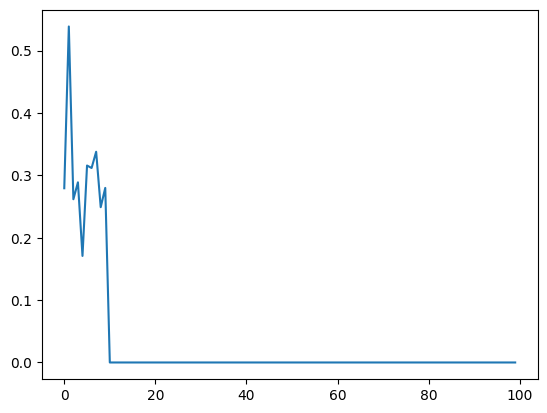

In [72]:
for batch in dataloader_reference:
    print(batch['intensity'])
    plt.plot(batch['intensity'][11])
    break

## forward

In [73]:
embeddings_reference = encoder.get_embeddings(dataloader_reference)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/sebas/miniconda3/envs/transformers/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [74]:
#embeddings_nist = encoder.get_embeddings(dataloader_nist)

In [75]:
#embeddings_gnps = encoder.get_embeddings(dataloader_gnps)

## compute similarities

In [76]:
similarities= CosineSimilarity.batch_cosine_similarity_combinations(embeddings_reference, embeddings_reference)

In [77]:
similarities.shape

(29540, 29540)

In [78]:
np.save('./matrix_similarities.npy', similarities)